# Simulated Controller

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline  
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [3]:
from ctrl.sim import Controller
from ctrl.algo import Proportional, PID, VelocityController

Continuous-time model is
$$
    \begin{align*}
    \dot{\omega} &= b u - a \omega, \\ \dot{x} &= \omega
    \end{align*}
$$

Units are:
* $x$ (cycles)
* $\omega$ (cycles/s), i.e. Hz

Motor characteristics:

* $48$ counts/turn
* $9.68:1$ gear ratio
* Encoder is at the high speed end
* Time constant $\tau = 1/17$s
* $11$ Hz @ $100\%$ duty

Model parameters:

* $a = 1/\tau = 17$ (1/s)
* $k = b/a = 11$ Hz / $100\%$ duty = $0.11$ Hertz/$\%$duty

In [4]:
a = 17   # 1/s
k = 0.11 # counts/s duty

Continuous time-model:
$$
\begin{align*}
    G(s) &= k \frac{1}{s} \frac{a}{s + a}, &
    k &= \frac{b}{a}
\end{align*}
$$

Zero-order hold equivalent ($T_s < \pi/a$):
$$
\begin{align*}
    G(z) &= k \frac{T_s}{2} \frac{z + 1}{z - 1} \frac{1 - c}{z - c} = 
        \frac{k T_s}{2} \frac{(1 - c) \, z + (1 - c)}{z^2 - (1 + c) \, z + c}, &
    c &= e^{-a T_s}
\end{align*}
$$

In [5]:
Ts = 0.01
c = math.exp(-a * Ts)

controller = Controller(Ts)
controller.set_model1( np.array((0, (k*Ts)*(1-c)/2, (k*Ts)*(1-c)/2)), 
                           np.array((1, -(1 + c), c)),
                           np.array((0,0)) )
print('num = {}'.format(controller.model1.num))
print('den = {}'.format(controller.model1.den))

num = [  0.00000000e+00   8.59843509e-05   8.59843509e-05]
den = [ 1.         -1.84366482  0.84366482]


## Open Loop

In [6]:
controller.calibrate()
controller.set_delta_mode(0)

> Calibrating period...
  ITER   TARGET   ACTUAL ACCURACY
     1  0.01000  0.01129   12.91%
     2  0.01000  0.01006    0.64%
< ...done.


In [8]:
controller.reset_logger()
controller.set_echo(0)
with controller:
    controller.set_reference1(0)
    time.sleep(1)
    controller.set_reference1(100)
    time.sleep(1)
    controller.set_reference1(-100)
    time.sleep(1)
    controller.set_reference1(0)
    time.sleep(1)

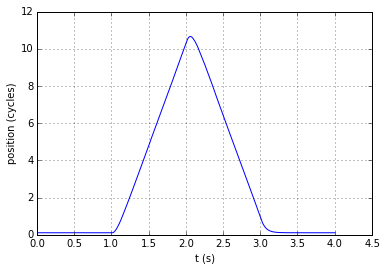

In [9]:
log = controller.get_log()
t = log[:,0]
position = log[:,1]
plt.plot(t, position)
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

## Closed-loop on Position (Proportional Control)

In [10]:
reference = 2
controller.set_controller1(Proportional(9 / k, reference / 100))

In [13]:
controller.reset_logger()
with controller:
    time.sleep(1)
    controller.set_reference1(100)
    time.sleep(3)
    controller.set_reference1(50)
    time.sleep(3)
    controller.set_reference1(-50)
    time.sleep(3)
log = controller.get_log()

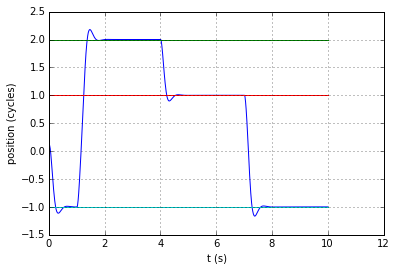

In [14]:
t = log[:,0]
position = log[:,1]
plt.plot(t, position, 
         (t[0],t[-1]), (reference, reference), 
         (t[0],t[-1]), (.5*reference, .5*reference),
         (t[0],t[-1]), (-.5*reference, -.5*reference))
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

## Closed-loop on Velocity (Proportional Control)

In [15]:
reference = 10
print('reference = {0:4.2f}'.format(reference))
controller.set_controller1(VelocityController(Proportional(5 / k, reference / 100)))

reference = 10.00


In [16]:
controller.reset_logger()
with controller:
    controller.set_reference1(0)
    time.sleep(1)
    controller.set_reference1(100)
    time.sleep(3)
    controller.set_reference1(50)
    time.sleep(3)
    controller.set_reference1(-50)
    time.sleep(3)
log = controller.get_log()

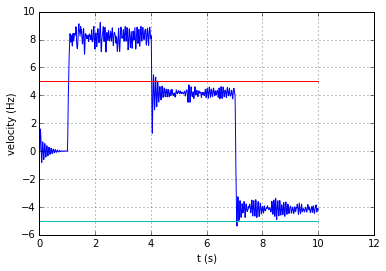

In [17]:
t = log[:,0]
velocity = np.zeros(t.shape, float)
velocity[1:] = (log[1:,1]-log[:-1,1])/controller.period
t = log[:,0]
plt.plot(t, velocity,
         (t[0],t[-1]), (reference, reference), 
         (t[0],t[-1]), (.5*reference, .5*reference),
         (t[0],t[-1]), (-.5*reference, -.5*reference))
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

### Closed-loop on Velocity (PI Control)

In [18]:
controller.set_controller1(VelocityController(PID(1 / k, a / k, 0, reference / 100)))

In [19]:
controller.reset_logger()
with controller:
    controller.set_reference1(0)
    time.sleep(1)
    controller.set_reference1(100)
    time.sleep(3)
    controller.set_reference1(50)
    time.sleep(3)
    controller.set_reference1(-50)
    time.sleep(3)
log = controller.get_log()

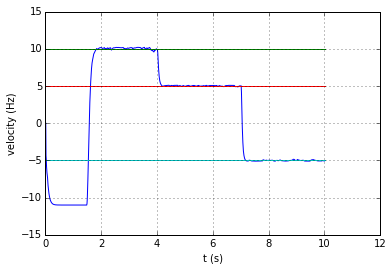

In [20]:
t = log[:,0]
velocity = np.zeros(t.shape, float)
velocity[1:] = (log[1:,1]-log[:-1,1])/controller.period
t = log[:,0]
plt.plot(t, velocity,
         (t[0],t[-1]), (reference, reference), 
         (t[0],t[-1]), (.5*reference, .5*reference),
         (t[0],t[-1]), (-.5*reference, -.5*reference))
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

### Closed-loop on Velocity (PI Control) Asynchronous

In [19]:
controller.reset_logger()
controller.start()
controller.set_reference1(100)

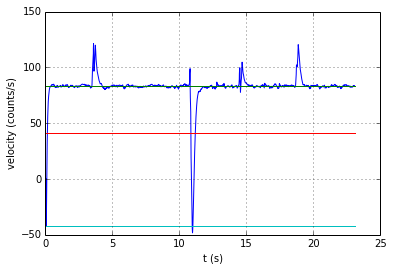

In [26]:
log = controller.get_log()
t = log[:,0]
velocity = np.zeros(t.shape, float)
velocity[1:] = (log[1:,1]-log[:-1,1])/controller.period
t = log[:,0]
plt.plot(t, velocity,
         (t[0],t[-1]), (reference, reference), 
         (t[0],t[-1]), (.5*reference, .5*reference),
         (t[0],t[-1]), (-.5*reference, -.5*reference))
plt.xlabel('t (s)')
plt.ylabel('velocity (counts/s)')
plt.grid()

In [24]:
controller.stop()